In [83]:
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor

)

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import (
    classification_report,
    mean_squared_error,
    confusion_matrix,
    plot_roc_curve
)

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split,
    cross_validate
)

from sklearn.preprocessing import StandardScaler

from sklearn.svm import (
    LinearSVC,
    SVC,
    SVR
)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
)

In [84]:
def evaluation_report(model, results, X_Train, Y_Train, X_Test, Y_Test, cv=10):
    """Prints a report and the cross validation score for a given classification model
    """

    print('Training set:\n')
    print(classification_report(Y_Train, results["pred_train"]))

    scores = cross_val_score(model, X_Train, Y_Train, cv=cv)
    print(f"{cv}-fold cross-validation scores for train: {scores.mean():.3f} (± {scores.std() * 2:.3f})")


    print('Testing set:\n')
    print(classification_report(Y_Test, results["pred_test"]))

    scores = cross_val_score(model, X_Test, Y_Test, cv=cv)
    print(f"{cv}-fold cross-validation scores for validation/test: {scores.mean():.3f} (± {scores.std() * 2:.3f})")

def regression_report(model, X, Y, cv=10):

    nmae = cross_val_score(model, X, Y, cv=5, scoring="neg_mean_absolute_error")
    print("\nMean absolute error: ", -np.mean(nmae))
    print(nmae)

    nmse = cross_val_score(model, X, Y, cv=5, scoring="neg_mean_squared_error")
    print("\nMean squared error: ", -np.mean(nmse))
    print(nmse)

    r2 = cross_val_score(model, X, Y, cv=5, scoring="r2")
    print("\nR2 score: ", np.mean(r2))
    print(r2)

    return {
        "nmae": nmae,
        "nmse": nmse,
        "r2": r2
    }

def model_predict(model, X, X_2):
    return {
        "pred_train": model.predict(X),
        "pred_test": model.predict(X_2)
        }

In [85]:
# from common_functions import *

In [86]:
df = pd.read_csv('winequality-red.csv', header=0, sep=";")
print("Red data shape: ", df.shape)
print("First 10 red data points:")
df.head(10)

Red data shape:  (1599, 12)
First 10 red data points:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


# Part 1

# Let's look at the distribution of the `quality` across all the samples

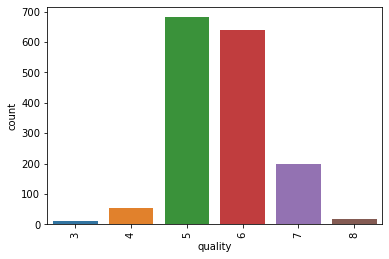

In [87]:
g = sns.countplot(x="quality", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

## As we can see, the data is heavily unbalanced
There are no samples of quality 1, 2, 9, or 10. Most of the samples are of quality 5 and 6.


In [88]:
# for v in df.columns:
#     g = sns.FacetGrid(df, col="quality", hue="quality")
#     g.map(sns.histplot, v)

# We'll discretise the alcohol content variable into Low, Mid, and High

- 0 <= **Low** < (average - standard deviation)
- (average - standard deviation) < **Mid** < (average + standard deviation)
- average + standard deviation > **High**

In [89]:
alcohol_std_dev = np.std(df["alcohol"])
alcohol_avg = np.mean(df["alcohol"])

low = alcohol_avg - alcohol_std_dev
high = alcohol_avg + alcohol_std_dev

bins = [0, low, high, np.max(df["alcohol"])+1]
labels = ["Low", "Mid", "High"]

df["alcohol_cat"] = pd.cut(df["alcohol"], bins=bins, labels=labels, right=False, include_lowest=True)

In [90]:
print(df["alcohol_cat"])

0       Mid
1       Mid
2       Mid
3       Mid
4       Mid
       ... 
1594    Mid
1595    Mid
1596    Mid
1597    Mid
1598    Mid
Name: alcohol_cat, Length: 1599, dtype: category
Categories (3, object): ['Low' < 'Mid' < 'High']


# We'll now look at the distributions again using the `alcohol_cat` variable we have created


In [91]:
# for v in df.columns:
#     g = sns.FacetGrid(df, col="alcohol_cat", hue="alcohol_cat")
#     g.map(sns.histplot, v)

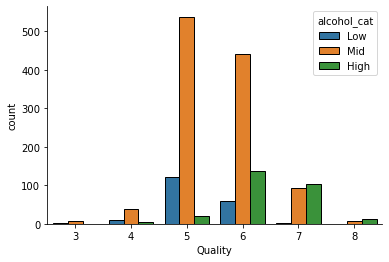

In [92]:
# https://stackoverflow.com/questions/40877135/plotting-two-columns-of-dataframe-in-seaborn

d = df.melt(id_vars="alcohol_cat", value_vars="quality", value_name="Quality")
# print(d)
sns.countplot(x="Quality", hue="alcohol_cat", data=d, edgecolor="k", linewidth=1)
sns.despine()

## We can see a relationship between alcohol content and quality. Low alcohol content wines tend to lower qualities (<6), while the High alcohol content wines tend to higher qualities. So, people perceive higher alcohol content wines as higher quality.

# We'll now plot the residual sugar variable to identify sweet and dry wines

Red wines are rarely sweet, so we should see their residual sugar at very low values. White wines can vary between dry and sweet, so their sugar values should be more spread out.
According to this article, dry wines generally have 0-5 g/L of residual sugars.

https://vinewineandwander.wordpress.com/2012/03/10/0-10-decoded/

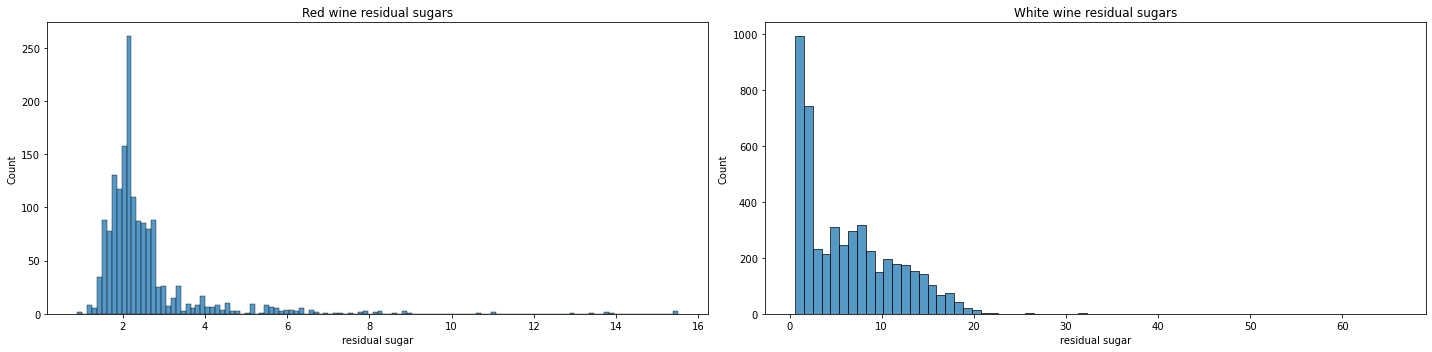

In [93]:
df_white = pd.read_csv('winequality-white.csv', header=0, sep=";")

fig, ax = plt.subplots(1,2, figsize=(20,5))

g = sns.histplot(df, x="residual sugar", ax=ax[0])
ax[0].set_title("Red wine residual sugars")

sns.histplot(df_white, x="residual sugar", ax=ax[1])
ax[1].set_title("White wine residual sugars")


plt.tight_layout()

In [94]:
df["residual sugar"].describe()

count    1599.000000
mean        2.538806
std         1.409928
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64

## From the above two plots, we can see that the majority of the red wines have below 3 g/L residual sugars, while the white wines have more variance.

# Let's create our threshold and identify each sample as sweet or dry.

We will say that wines with residual sugar levels in the 80th percentile are classed as "sweet".

In [95]:
# sugar_threshold = np.percentile(df["residual sugar"], q=80)  # Anything below is considered dry, anything above is sweet
sugar_threshold = np.median(df["residual sugar"])  # This will split the classes evenly, as sugar is skewed in these datasets
print(sugar_threshold)

bins = [0, sugar_threshold, np.max(df["residual sugar"])+1]
labels = ["Not sweet", "Sweet"]

df["isSweet"] = pd.cut(df["residual sugar"], bins=bins, labels=labels, right=False, include_lowest=True)

2.2


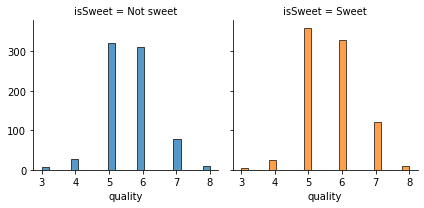

In [96]:
g = sns.FacetGrid(df, col="isSweet", hue="isSweet")
g.map(sns.histplot, "quality")

## We can see that the distribution remains the same. This means that the sweetness does not affect the perceived quality of the wines in this case.

# Part 2
## Let's look at correlations between variables to determine which would be good to analyse

In [97]:
#sns.pairplot(df)

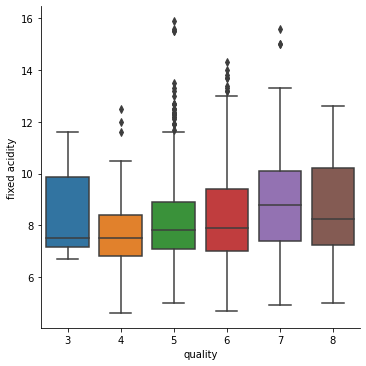

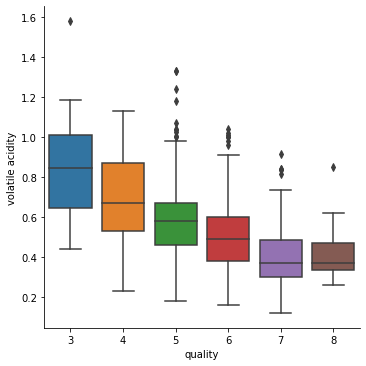

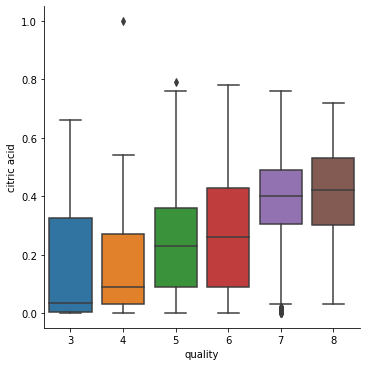

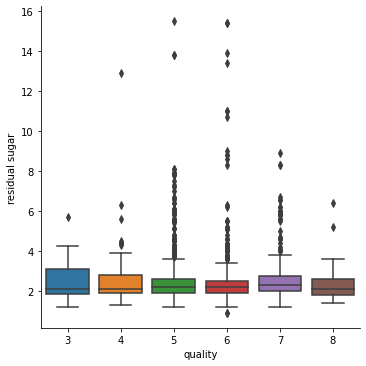

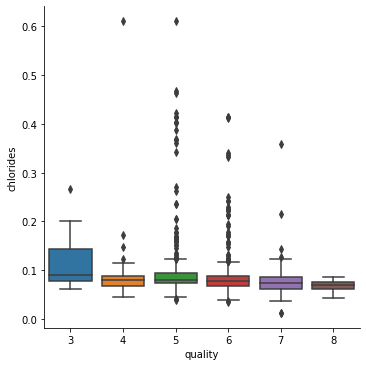

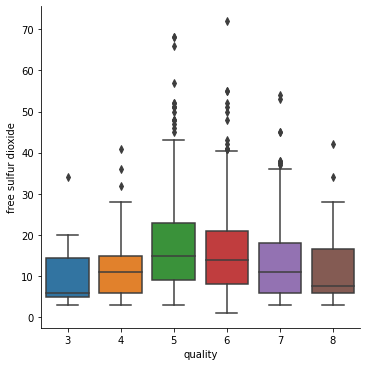

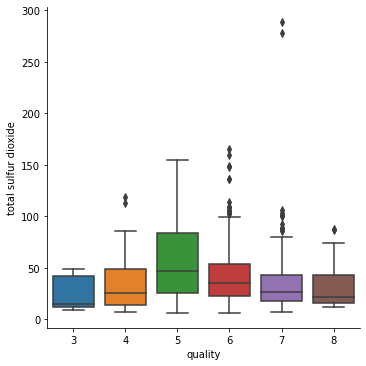

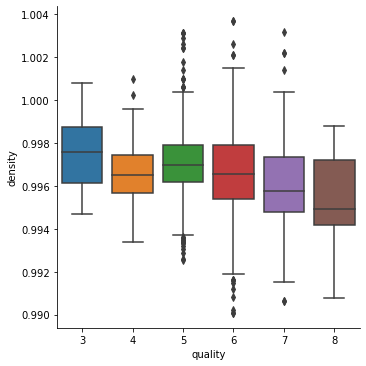

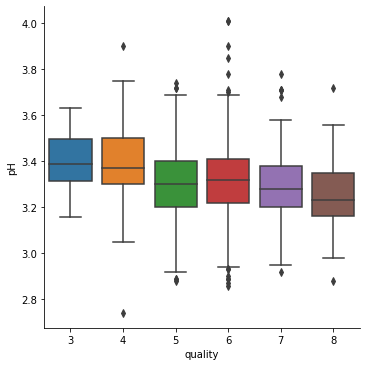

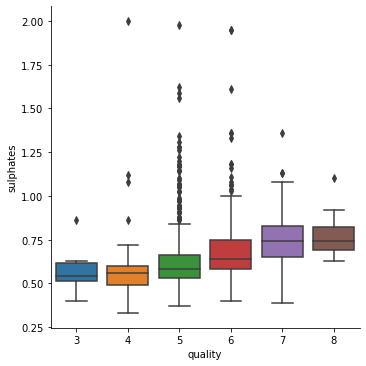

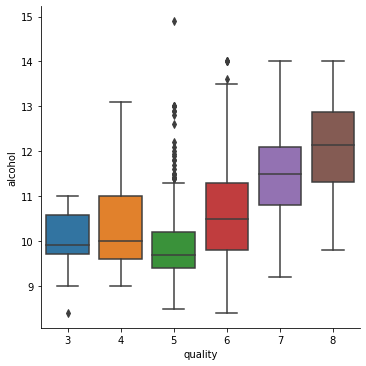

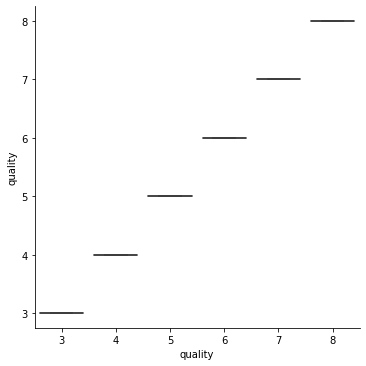

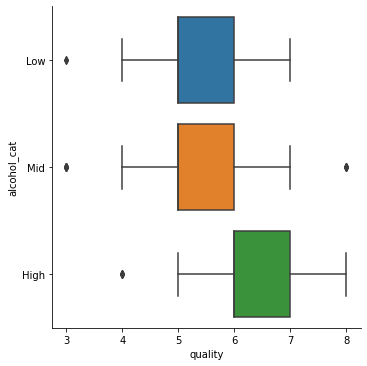

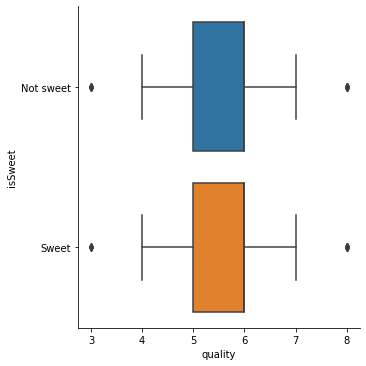

In [98]:
for v in df.columns:
    g = sns.catplot(x="quality", y=v, data=df, kind="box")

# As the data is approximately normally distributed, we can use Pearson correlation

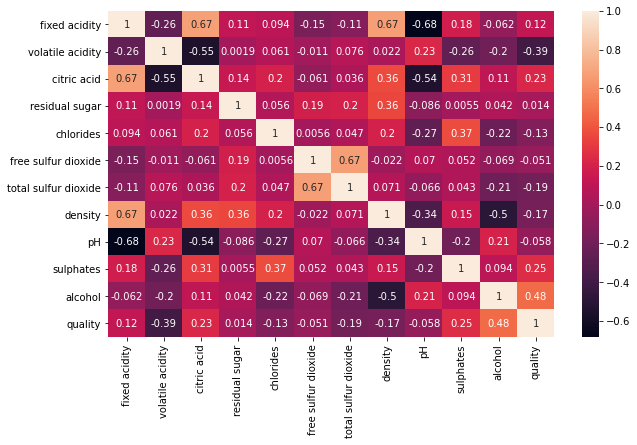

In [99]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(df.corr(method="pearson"), annot=True)

# We can see that volatile acidity, citric acid, sulphates, and alcohol have the highest correlation with quality in the sample. They both have moderate correlation

# Part 3

https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/

In [100]:
df["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

## We can see that the data is heavily unbalanced. We can try to amplify minorities using SMOTE later

# 3.1 Binary Classification
We'll first try to consider this as a binary classification to classify wines as either high or low quality. Low quality wines are those with quality less than 6, and high qualities are 6 or higher.

In [101]:
low = 6  # Anything <= 6 is considered low, anything above is high
high = np.max(df["quality"])

bins = [0, low, high+1]
labels = [0, 1]

df["quality_bin"] = pd.cut(df["quality"], bins=bins, labels=labels, right=False, include_lowest=True)
df["quality_bin"].describe()

count     1599
unique       2
top          1
freq       855
Name: quality_bin, dtype: int64

In [102]:
col = ["isSweet", "alcohol_cat"]

for c in col:
    dummies = []
    dummies.append(pd.get_dummies(df[c]))
    df_dummies = pd.concat(dummies, axis=1)
    df = pd.concat((df, df_dummies), axis=1)
    df = df.drop([c], axis=1)

df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_bin,Not sweet,Sweet,Low,Mid,High
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,1,0,0,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,0,1,0,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,0,1,0,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,1,0,0,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,1,0,0,1,0


# Split data

In [103]:
from collections import Counter

# Drop quality and binary quality. If we don't drop quality, all models get 100% accuracy
# X = df.drop(["quality", "quality_bin", "free sulfur dioxide", "residual sugar", "fixed acidity", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH"], axis=1).values
# X = df.drop(["quality", "quality_bin"], axis=1).values
X = df.filter(["volatile acidity", "citric acid", "sulphates", "Low", "Mid", "High"]).to_numpy()
# X = df.filter(["volatile acidity", "citric acid", "sulphates", "alcohol"]).to_numpy()
Y = df["quality_bin"].to_numpy()

XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.20, random_state=7, shuffle=True)

XTrainV, XVal, YTrainV, YVal = train_test_split(XTrain, YTrain, test_size=0.25, random_state=7, shuffle=True)

print(f"Training set counts: \n{Counter(YTrain)}\n")
print(f"Smaller training set counts \n{Counter(YTrainV)}\n")
print(f"Validation set counts: \n{Counter(YVal)}\n")
print(f"Test set counts: \n{Counter(YTest)}\n")

scaler = StandardScaler()
XTrain, XTrainV, XTest, XVal = (scaler.fit_transform(d) for d in (XTrain, XTrainV, XTest, XVal))

Training set counts: 
Counter({1: 668, 0: 611})

Smaller training set counts 
Counter({1: 505, 0: 454})

Validation set counts: 
Counter({1: 163, 0: 157})

Test set counts: 
Counter({1: 187, 0: 133})



## Data can be rebalanced using SMOTE. This amplifies the minority class in the hopes to improve results.
In practice, was making precision on minority class lower while recall was higher

Link: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [104]:
# over = SMOTE(sampling_strategy=0.3)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# print(f"Unbalanced Counts:\n{Counter(YTrain)}\n")

# XTrain, YTrain = SMOTE().fit_resample(XTrain, YTrain)
# XTrain, YTrain = pipeline.fit_resample(XTrain, YTrain)


# print(f"Balanced Counts:\n{Counter(YTrain)}\n")

# Logistic Regression

See here for info on cross validation: https://machinelearningmastery.com/k-fold-cross-validation/

https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85

Training set:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       611
           1       0.75      0.66      0.70       668

    accuracy                           0.71      1279
   macro avg       0.71      0.71      0.71      1279
weighted avg       0.71      0.71      0.71      1279

10-fold cross-validation scores for train: 0.700 (± 0.061)
Testing set:

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       157
           1       0.75      0.67      0.71       163

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.713 (± 0.191)


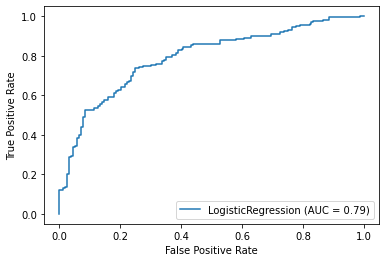

In [105]:
logit_model = LogisticRegression(solver="lbfgs", multi_class="auto", C=1, max_iter=10000)
logit_model.fit(XTrain, YTrain)

results = model_predict(logit_model, XTrain, XVal)
evaluation_report(logit_model, results, XTrain, YTrain, XVal, YVal)
confusion_matrix(YVal, results["pred_test"])

plot_roc_curve(logit_model, XVal, YVal)

## Let's tune the hyper-parameter C for Logistic Regression

In [106]:
tuned_parameters = {"C": [0.1, 1, 10, 100]}

clf = GridSearchCV(LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=10000), tuned_parameters, cv=5)
clf.fit(XTrainV, YTrainV)

print("Best parameters set found on development set:\n")
bp = clf.best_params_
print(bp)

Best parameters set found on development set:

{'C': 1}


Training set:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       611
           1       0.75      0.66      0.70       668

    accuracy                           0.71      1279
   macro avg       0.71      0.71      0.71      1279
weighted avg       0.71      0.71      0.71      1279

10-fold cross-validation scores for train: 0.700 (± 0.061)
Testing set:

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       157
           1       0.75      0.67      0.71       163

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.713 (± 0.191)


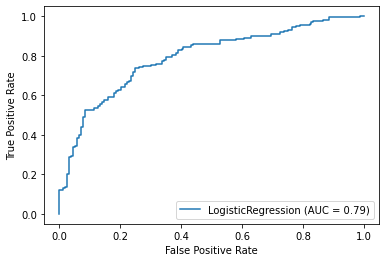

In [107]:
logit_model = LogisticRegression(solver="lbfgs", multi_class="auto", C=bp["C"], max_iter=10000)
logit_model.fit(XTrain, YTrain)
results = model_predict(logit_model, XTrain, XVal)
evaluation_report(logit_model, results, XTrain, YTrain, XVal, YVal)
confusion_matrix(YVal, results["pred_test"])

plot_roc_curve(logit_model, XVal, YVal)

# Evaluation
Finally, we'll test the model using the test set to evaluate

Training set:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       611
           1       0.75      0.66      0.70       668

    accuracy                           0.71      1279
   macro avg       0.71      0.71      0.71      1279
weighted avg       0.71      0.71      0.71      1279

10-fold cross-validation scores for train: 0.700 (± 0.061)
Testing set:

              precision    recall  f1-score   support

           0       0.62      0.80      0.70       133
           1       0.82      0.65      0.72       187

    accuracy                           0.71       320
   macro avg       0.72      0.72      0.71       320
weighted avg       0.73      0.71      0.71       320

10-fold cross-validation scores for validation/test: 0.716 (± 0.126)


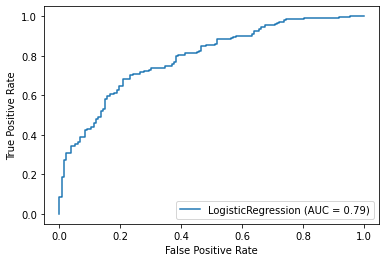

In [108]:
results = model_predict(logit_model, XTrain, XTest)
evaluation_report(logit_model, results, XTrain, YTrain, XTest, YTest)
confusion_matrix(YTest, results["pred_test"])

plot_roc_curve(logit_model, XTest, YTest)

# SVM Linear
Maybe get rid of this?

Training set:

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       611
           1       0.75      0.65      0.70       668

    accuracy                           0.70      1279
   macro avg       0.71      0.71      0.70      1279
weighted avg       0.71      0.70      0.70      1279

10-fold cross-validation scores for train: 0.698 (± 0.059)
Testing set:

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       157
           1       0.76      0.66      0.71       163

    accuracy                           0.72       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.703 (± 0.190)


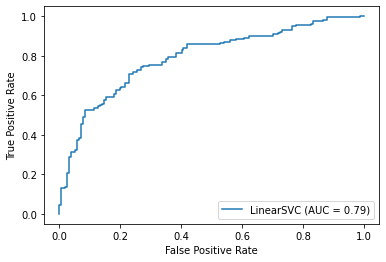

In [109]:
lsvm = LinearSVC(dual=False)
lsvm.fit(XTrain, YTrain)
results = model_predict(lsvm, XTrain, XVal)
evaluation_report(lsvm, results, XTrain, YTrain, XVal, YVal)

plot_roc_curve(lsvm, XVal, YVal)

# Let's tune the hyperparameter C

In [110]:
tuned_parameters = {"C": [0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(LinearSVC(dual=False), tuned_parameters, cv=10)
clf.fit(XVal, YVal)

print("Best parameters set found on development set:\n")
bp = clf.best_params_
print(bp)

Best parameters set found on development set:

{'C': 0.01}


# Evaluation

Training set:

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       611
           1       0.75      0.65      0.70       668

    accuracy                           0.70      1279
   macro avg       0.71      0.71      0.70      1279
weighted avg       0.71      0.70      0.70      1279

10-fold cross-validation scores for train: 0.698 (± 0.059)
Testing set:

              precision    recall  f1-score   support

           0       0.62      0.80      0.70       133
           1       0.82      0.65      0.73       187

    accuracy                           0.72       320
   macro avg       0.72      0.73      0.71       320
weighted avg       0.74      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.713 (± 0.118)


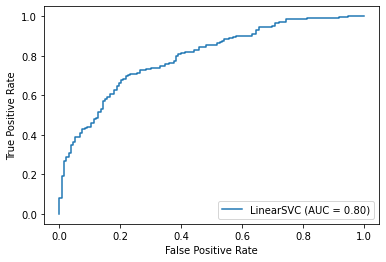

In [111]:
results = model_predict(lsvm, XTrain, XTest)
evaluation_report(lsvm, results, XTrain, YTrain, XTest, YTest)
confusion_matrix(YTest, results["pred_test"])

plot_roc_curve(lsvm, XTest, YTest)

# Non-linear SVM
See here: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html for explanation of kernel types


Training set:

              precision    recall  f1-score   support

           0       0.66      0.83      0.73       611
           1       0.80      0.60      0.69       668

    accuracy                           0.71      1279
   macro avg       0.73      0.72      0.71      1279
weighted avg       0.73      0.71      0.71      1279

10-fold cross-validation scores for train: 0.708 (± 0.059)
Testing set:

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       157
           1       0.85      0.64      0.73       163

    accuracy                           0.76       320
   macro avg       0.77      0.76      0.75       320
weighted avg       0.77      0.76      0.75       320

10-fold cross-validation scores for validation/test: 0.709 (± 0.112)


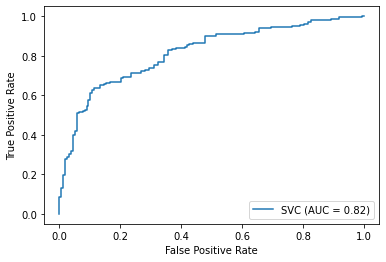

In [112]:
svm = SVC(kernel="poly")
svm.fit(XTrain, YTrain)
results = model_predict(svm, XTrain, XVal)
evaluation_report(svm, results, XTrain, YTrain, XVal, YVal, 10)

plot_roc_curve(svm, XVal, YVal)

# Let's experiment with different SVM kernels and parameters

In [113]:
tuned_parameters = [{
    "kernel": ["rbf"],
    "C": [0.01, 1, 10, 100],
    "gamma": ["auto", 0.01, 0.1, 1]
},
{
    "kernel": ["poly"],
    "degree": [2, 3],
    "C": [0.01, 1, 10, 100],
    "gamma": ["auto", 0.01, 0.1, 1]
}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=3, verbose=2)
clf.fit(XVal, YVal)

print("Best parameters set found on development set:\n")
bp = clf.best_params_
print(bp)


............
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf ...............................

Training set:

              precision    recall  f1-score   support

           0       0.67      0.79      0.72       611
           1       0.77      0.64      0.70       668

    accuracy                           0.71      1279
   macro avg       0.72      0.72      0.71      1279
weighted avg       0.72      0.71      0.71      1279

10-fold cross-validation scores for train: 0.705 (± 0.052)
Testing set:

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       157
           1       0.78      0.65      0.71       163

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.74      0.73      0.73       320

10-fold cross-validation scores for validation/test: 0.722 (± 0.152)


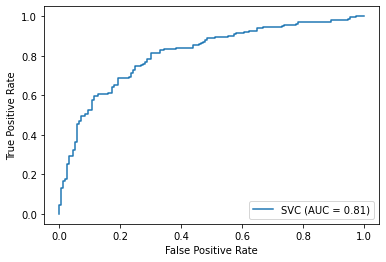

In [114]:
svm = SVC(kernel=bp["kernel"], gamma=bp["gamma"], C=bp["C"])
svm.fit(XTrain, YTrain)
results = model_predict(svm, XTrain, XVal)
evaluation_report(svm, results, XTrain, YTrain, XVal, YVal, 10)

plot_roc_curve(svm, XVal, YVal)

# Evaluation

Training set:

              precision    recall  f1-score   support

           0       0.67      0.79      0.72       611
           1       0.77      0.64      0.70       668

    accuracy                           0.71      1279
   macro avg       0.72      0.72      0.71      1279
weighted avg       0.72      0.71      0.71      1279

10-fold cross-validation scores for train: 0.705 (± 0.052)
Testing set:

              precision    recall  f1-score   support

           0       0.62      0.81      0.71       133
           1       0.83      0.65      0.73       187

    accuracy                           0.72       320
   macro avg       0.73      0.73      0.72       320
weighted avg       0.74      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.741 (± 0.131)


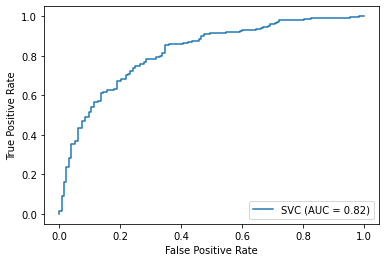

In [115]:
results = model_predict(svm, XTrain, XTest)
evaluation_report(svm, results, XTrain, YTrain, XTest, YTest, 10)
confusion_matrix(YTest, results["pred_test"])

plot_roc_curve(svm, XTest, YTest)

# K Nearest Neighbours Classifier

In [116]:
knn = KNeighborsClassifier()
knn.fit(XTrain, YTrain)
results = model_predict(knn, XTrain, XVal)

evaluation_report(knn, results, XTrain, YTrain, XVal, YVal)

Training set:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       611
           1       0.80      0.80      0.80       668

    accuracy                           0.79      1279
   macro avg       0.79      0.79      0.79      1279
weighted avg       0.79      0.79      0.79      1279

10-fold cross-validation scores for train: 0.684 (± 0.073)
Testing set:

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       157
           1       0.80      0.77      0.78       163

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.79      0.78      0.78       320

10-fold cross-validation scores for validation/test: 0.700 (± 0.156)


# Hyperparameter tuning

In [117]:
tuned_parameters = [{
    "n_neighbors": [i for i in range(1,6)],
    "p": [1, 2],
    "leaf_size": [i for i in range(10, 51, 10)],
    "weights": ["uniform", "distance"]
    }]
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, verbose=1)
clf.fit(XVal, YVal)

print("Best parameters set found on development set:\n")
bp = clf.best_params_
print(bp)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Best parameters set found on development set:

{'leaf_size': 10, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished


# Evaluation

Training set:

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       611
           1       0.90      0.70      0.78       668

    accuracy                           0.80      1279
   macro avg       0.82      0.81      0.80      1279
weighted avg       0.82      0.80      0.80      1279

10-fold cross-validation scores for train: 0.680 (± 0.057)
Testing set:

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       133
           1       0.83      0.64      0.73       187

    accuracy                           0.72       320
   macro avg       0.73      0.73      0.72       320
weighted avg       0.74      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.713 (± 0.078)


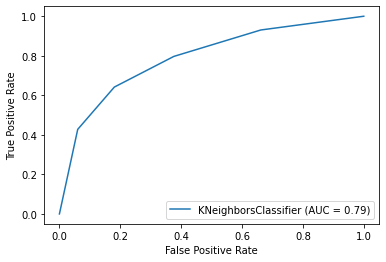

In [118]:
knn = KNeighborsClassifier(n_neighbors=bp["n_neighbors"], p=bp["p"], leaf_size=bp["leaf_size"], weights=bp["weights"])
knn.fit(XTrain, YTrain)
results = model_predict(knn, XTrain, XTest)
evaluation_report(knn, results, XTrain, YTrain, XTest, YTest)

plot_roc_curve(knn, XTest, YTest)

# Random Forest Classifier

In [119]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=20)
rfc.fit(XTrain, YTrain)
results = model_predict(rfc, XTrain, XVal)

evaluation_report(rfc, results, XTrain, YTrain, XVal, YVal)

Training set:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       611
           1       0.99      1.00      0.99       668

    accuracy                           0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

10-fold cross-validation scores for train: 0.761 (± 0.053)
Testing set:

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       157
           1       0.81      0.78      0.80       163

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320

10-fold cross-validation scores for validation/test: 0.697 (± 0.134)


## Let's tune the hyper parameters n_estimators and max_depth, and then retrain the model

In [120]:
# scores = ['precision', 'recall']

tuned_parameters = {"n_estimators": [10,50,100,200],
                     "max_depth": [5,10,20,50],
                     "class_weight": ["balanced", None]
                     }
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, verbose=1)
clf.fit(XVal, YVal)

print("Best parameters set found on development set:\n")
print(clf.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   33.0s finished
Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}


# Evaluation

Training set:

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       611
           1       0.82      0.66      0.73       668

    accuracy                           0.75      1279
   macro avg       0.76      0.75      0.75      1279
weighted avg       0.76      0.75      0.75      1279

10-fold cross-validation scores for train: 0.711 (± 0.050)
Testing set:

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       133
           1       0.84      0.64      0.73       187

    accuracy                           0.72       320
   macro avg       0.73      0.74      0.72       320
weighted avg       0.75      0.72      0.72       320

10-fold cross-validation scores for validation/test: 0.741 (± 0.089)


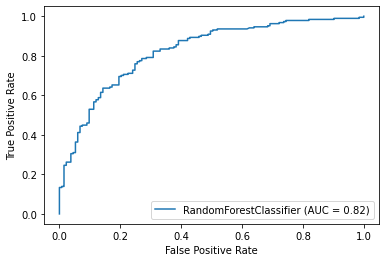

In [121]:
rfc = RandomForestClassifier(n_estimators=clf.best_params_["n_estimators"], max_depth=clf.best_params_["max_depth"], class_weight="balanced")
rfc.fit(XTrain, YTrain)
results = model_predict(rfc, XTrain, XTest)
evaluation_report(rfc, results, XTrain, YTrain, XTest, YTest)

plot_roc_curve(rfc, XTest, YTest)

# 3.2 Regression
We will now consider this as a regression problem. Quality is now a continuous variable. We'll need to reload the data

In [122]:
# Drop quality and binary quality. If we don't drop quality, all models get 100% accuracy
# X = df.drop(["quality", "quality_bin", "free sulfur dioxide", "residual sugar", "fixed acidity", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH"], axis=1).values
# X = df.drop(["quality", "quality_bin"], axis=1).to_numpy()

# X = df.filter(["volatile acidity", "citric acid", "sulphates", "Low", "Mid", "High"]).values
X = df.filter(["volatile acidity", "citric acid", "sulphates", "alcohol"]).to_numpy()

Y = df["quality"].to_numpy()

XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.20, random_state=7, shuffle=True)

XTrain, XVal, YTrain, YVal = train_test_split(XTrain, YTrain, test_size=0.25, random_state=7, shuffle=True)

scaler = StandardScaler()
XTrain, XTest, XVal = (scaler.fit_transform(d) for d in (XTrain, XTest, XVal))
# XTrain = scaler.fit_transform(XTrain)
# XTest = scaler.fit_transform(XTest)

# XTrain, YTrain = SMOTE(k_neighbors=3).fit_resample(XTrain, YTrain)

# Linear Regression

In [123]:
from sklearn.metrics import mean_squared_error

lrm = LinearRegression(fit_intercept=True)
lrm.fit(XTrain, YTrain)

results = regression_report(lrm, XVal, YVal)



Mean absolute error:  0.5029001069547402
[-0.49602307 -0.57092487 -0.54096976 -0.54009447 -0.36648836]

Mean squared error:  0.4582862700902517
[-0.48546622 -0.60843802 -0.4880181  -0.47163552 -0.23787349]

R2 score:  0.33755099791219545
[0.36894013 0.09932702 0.45622358 0.26266447 0.50059979]


## We can see that the R2 score is quite low for linear regression, meaning that the model does not fit the data well. Let's try another model

# Random Forest

In [124]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=100)
rfr.fit(XTrain, YTrain)

results = regression_report(rfr, XVal, YVal)


Mean absolute error:  0.5265
[-0.52125    -0.59265625 -0.55890625 -0.55796875 -0.40171875]

Mean squared error:  0.49141874999999996
[-0.51147031 -0.62898906 -0.53860781 -0.51334062 -0.26468594]

R2 score:  0.2968782042769543
[0.32211996 0.09159783 0.41289227 0.2300971  0.42768385]


# Hyper parameter tuning

In [125]:
tuned_parameters = {
    "n_estimators": [10,50,100,200],
    "max_depth": [5,10,20,50],
    "criterion": ["mse", "mae"]
}

clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, verbose=1)
clf.fit(XVal, YVal)

bp = clf.best_params_
print(bp)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.9min finished
{'criterion': 'mse', 'max_depth': 50, 'n_estimators': 50}


In [126]:
rfr = RandomForestRegressor(max_depth=bp["max_depth"], n_estimators=bp["n_estimators"], criterion=bp["criterion"])
rfr.fit(XTrain, YTrain)

results = regression_report(rfr, XTest, YTest)


Mean absolute error:  0.49312500000000004
[-0.4340625 -0.444375  -0.535     -0.5428125 -0.509375 ]

Mean squared error:  0.38685374999999994
[-0.28614375 -0.31095    -0.39714375 -0.4332     -0.50683125]

R2 score:  0.27815634143878676
[0.38382869 0.16802569 0.04575609 0.41346151 0.37970973]


# Support vector machine

In [127]:
# svr = svm_model_regression(XTrain, XTest, YTrain, YTest, kernel="sigmoid")

svr = SVR(kernel="poly")
svr.fit(XTrain, YTrain)

results = regression_report(svr, XVal, YVal)


Mean absolute error:  0.597123890790557
[-0.56857404 -0.63121157 -0.64183095 -0.60041505 -0.54358784]

Mean squared error:  0.5996617050424097
[-0.56676195 -0.67695131 -0.72134555 -0.62911231 -0.40413741]

R2 score:  0.12508368258177663
[ 0.26326343 -0.00209345  0.19623739  0.01647175  0.1515393 ]


# Let's tune the hyper parameters for the SVM

In [128]:
tuned_parameters = [{
    "kernel": ["rbf"],
    "C": [0.01, 1, 10],
    "gamma": ["auto", 0.01, 0.1, 1],
    "epsilon": [0.01, 0.02, 0.03, 0.04, 0.05]
}]

clf = GridSearchCV(SVR(), tuned_parameters, cv=5, verbose=1)
clf.fit(XVal, YVal)

print("Best parameters set found on development set:\n")
bp = clf.best_params_
print(bp)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Best parameters set found on development set:

{'C': 1, 'epsilon': 0.04, 'gamma': 0.01, 'kernel': 'rbf'}
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   12.2s finished


In [129]:
svr = SVR(kernel=bp["kernel"], gamma=bp["gamma"], C=bp["C"], epsilon=0.04)
svr.fit(XTrain, YTrain)

results = regression_report(svr, XTest, YTest)


Mean absolute error:  0.4741641804352555
[-0.42991016 -0.41814973 -0.484776   -0.53140029 -0.50658472]

Mean squared error:  0.3672368688181186
[-0.28025522 -0.28678276 -0.35527901 -0.4802998  -0.43356755]

R2 score:  0.335939758187824
[0.42023971 0.21427279 0.19109347 0.36105619 0.49303663]
